## PRACTICA OBLIGATORIA: **Ensamblado de modelos, bagging, boosting, random forest y gbts**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


In [74]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menoss tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

In [75]:
#Cargo el dataset y le echo un vistazo
# Cargar el dataset desde la URL

data = pd.read_csv(url, names=names)

# Visualizar las primeras filas del dataset
print(data.head())

# Ver información general sobre el dataset
print(data.info())

# Descripción estadística de las variables
print(data.describe())

   preg  plas  pres  skin  test  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
             preg        plas        pres        skin        test        mass  \
count  768

RangeIndex: Tenemos 768 registros en 9 columnas. No hay valores nulos en principio y todos son enteros o float.
7 columnas son eneteros (preg, plas, pres, skin, test, age y class) y 2 son float (mass y pedi). La variable objetivo es class y está en formato int (son ceros y unos)
Algún problema:
plas (glucosa): tiene valores 0 lo cual no tiene sentido
pres (presión arterial): tampoco puede ser 0
skin (pliegue cutáneo): podría haber nulos por mala medición y también hay algún cero, no paraece posible que haya gente "sin pliegue"
test (insulina): también tiene valores 0, no puede ser.
Parece que class está desbalanceado porque la media es 0.35, lo que quiere decir que sólo el 35% de los casos son diabéticos, son unos. 

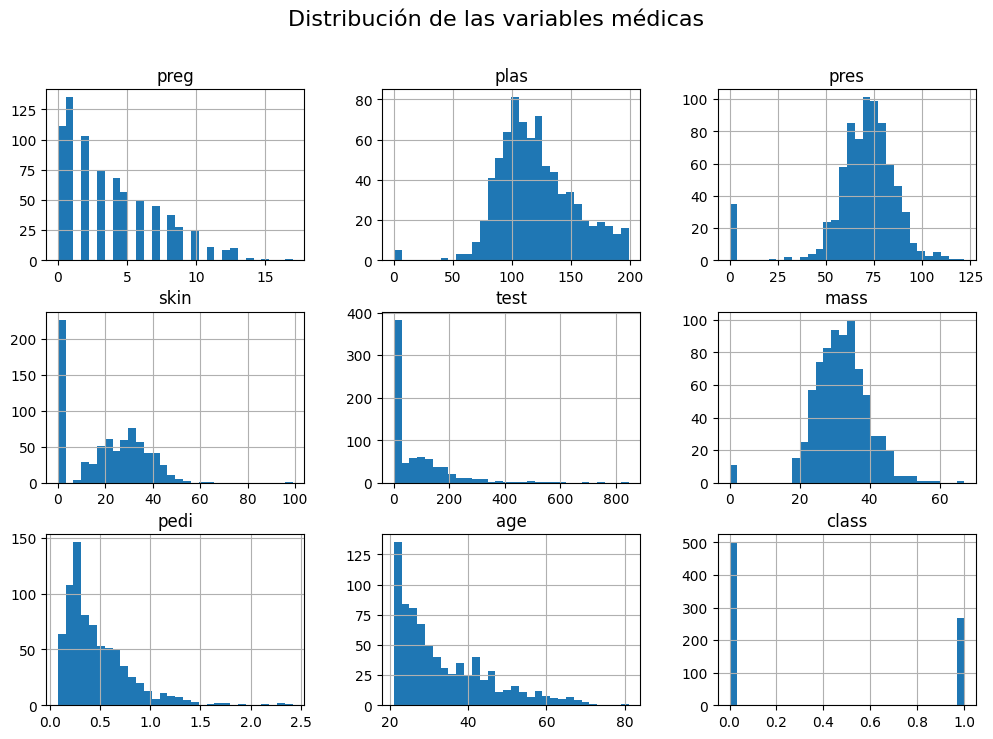

In [76]:
# Visualización de todas las variables numéricas
def plot_dataset(data):
    data.hist(figsize=(12, 8), bins=30)
    plt.suptitle("Distribución de las variables médicas", fontsize=16)
    plt.show()

plot_dataset(data)

preg es claramente categórica. Podríamos agrupar en 0 embarazos, 1 y 2 embarazos, de 3 a 5 y 6 o más embarazos para no tener tantísimas categorías.  
Ya hemos visto que plas tiene 0 y que no tiene sentido. Los tenemos que poner cono NaN y tratarlos como faltantes.  
Pres tieen un pico en 0 que no tiene ningún sentido. También los sustituiré por NaN.  
Fuerte pico en 0 para skin. Hay que decidir cómo manejar los faltantes, en principio les pondré NaN pero hay muchísimos.  
Lo mismo pasa con test.  
Mass se pueden poner los ceros como NaN y dejarla tal cual está.  
pedi y age se cargarán como están.




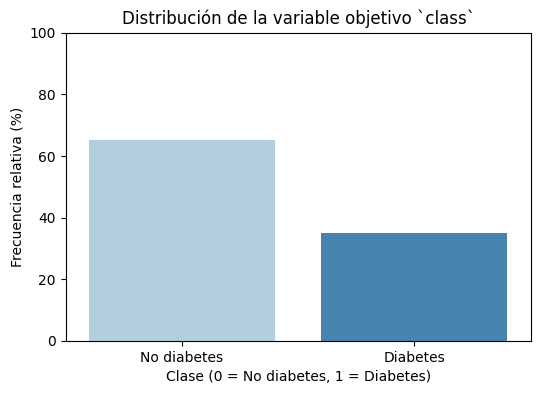

In [77]:
#Veamos las frecuencias relativas de class:
# Calculamos la proporción de cada clase
class_counts = data['class'].value_counts(normalize=True) * 100

# Graficamos la distribución
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="Blues", legend=False)

# Añadimos etiquetas
plt.xlabel("Clase (0 = No diabetes, 1 = Diabetes)")
plt.ylabel("Frecuencia relativa (%)")
plt.title("Distribución de la variable objetivo `class`")
plt.xticks([0, 1], ["No diabetes", "Diabetes"])
plt.ylim(0, 100)
plt.show()

Como se decía antes está algo desbalanceada.

In [78]:
#sustituyo los 0 por NaN
# Variables que tienen valores 0 como datos faltantes
columns_to_replace = ['plas', 'pres', 'skin', 'test', 'mass']

# Sustituimos los 0 por NaN
data[columns_to_replace] = data[columns_to_replace].replace(0, np.nan)

# Verificamos cuántos valores NaN hay ahora
print(data.isnull().sum())

preg       0
plas       5
pres      35
skin     227
test     374
mass      11
pedi       0
age        0
class      0
dtype: int64


In [79]:
# Variables que tienen valores 0 como datos faltantes
columns_to_replace_mean = ['plas', 'pres', 'mass']
columns_to_replace_median = ['skin', 'test']

# Imputación por media
data.update(data[columns_to_replace_mean].apply(lambda col: col.fillna(col.mean())))

# Imputación por mediana
data.update(data[columns_to_replace_median].apply(lambda col: col.fillna(col.median())))

# Verificamos que ya no haya valores NaN
print(data.isnull().sum())

preg     0
plas     0
pres     0
skin     0
test     0
mass     0
pedi     0
age      0
class    0
dtype: int64


In [80]:
#Divido en train y test

# Definimos la variable objetivo y las características
X = data.drop(columns=['class'])  # Variables predictoras
y = data['class']  # Variable objetivo

# Dividimos en 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificamos tamaños
print(f"Tamaño de Train: {X_train.shape[0]} muestras")
print(f"Tamaño de Test: {X_test.shape[0]} muestras")

Tamaño de Train: 614 muestras
Tamaño de Test: 154 muestras


In [81]:
#Entreno el modelo base

# Creamos el modelo de regresión logística
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Entrenamos el modelo
logistic_model.fit(X_train, y_train)

# Ahora podemos hacer predicciones
y_pred_base = logistic_model.predict(X_test)

Rendimiento del modelo base: regresión logística. Matriz de confusión

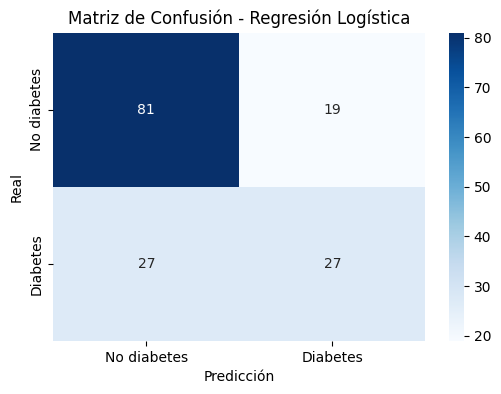

In [82]:
# Predicción con el modelo base
y_pred_base = logistic_model.predict(X_test)

# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_base)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No diabetes', 'Diabetes'], yticklabels=['No diabetes', 'Diabetes'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

81 No diabéticos predichos como no diabéticos: buena capacidad de identificar pacientes sin diabetes  
27 diabéticos que eran diabéticos: Detecta correctamente la diabetes en elgunos casos.  
19 falsos positivos: el modelo es demasiado agresivo al predecir personas con diabetes  
27 falsos negativos: el modelo falla en detectar algunos casos de diabetes.  

El modelo base no es muy bueno.

In [83]:
# Cálculo de métricas
accuracy = accuracy_score(y_test, y_pred_base)
precision = precision_score(y_test, y_pred_base)
recall = recall_score(y_test, y_pred_base)
f1 = f1_score(y_test, y_pred_base)

# Mostramos los resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7013
Precision: 0.5870
Recall: 0.5000
F1-Score: 0.5400


Con un accuracy de 70% el modelo clasifica bien la mayoría de los casos aunque no es un valor suficientemente alto teniendo en cuenta que se trata de la salud de las personas.  
Precission 58% , de las predicciones de diabetes sólo el 58% son correctas.  
Recall 50%: Sólo detecta la mitad de los casos reales de diabetes. No es suficiente.  
F1-Score 54%: Balance entre precision y recall confirmando que el modelo no captura bien los casos de diabetes.

Voy a probar Random Forest:

In [84]:
# Creamos el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Entrenamos el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluamos las métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Mostramos los resultados
print(f"Accuracy (RF): {accuracy_rf:.4f}")
print(f"Precision (RF): {precision_rf:.4f}")
print(f"Recall (RF): {recall_rf:.4f}")
print(f"F1-Score (RF): {f1_rf:.4f}")

Accuracy (RF): 0.7403
Precision (RF): 0.6400
Recall (RF): 0.5926
F1-Score (RF): 0.6154


### 🔎 Comparación de modelos

| Métrica       | Regresión Logística | Random Forest |
|--------------|-------------------|--------------|
| **Accuracy**  | 70.13%             | **74.03%**  |
| **Precision** | 58.70%             | **64.00%**  |
| **Recall**    | 50.00%             | **59.26%**  |
| **F1-Score**  | 54.00%             | **61.54%**  |

Como se puede ver todos los parámetros han mejorado con Random Forest.

In [85]:
#Feature Importance

rf_model.feature_importances_


array([0.07543797, 0.27159585, 0.07855719, 0.07390273, 0.09361048,
       0.17086339, 0.11703008, 0.11900231])

<Axes: >

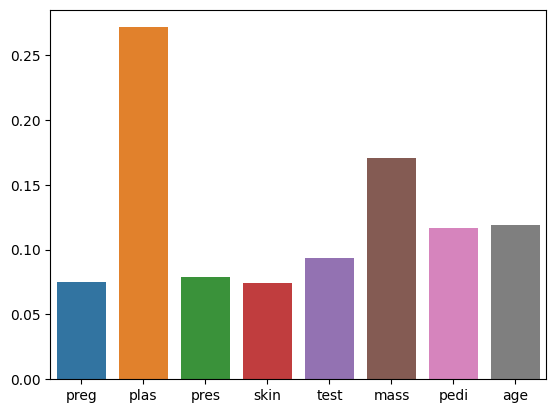

In [86]:
classes = X.columns.values.tolist()
sns.barplot(x=classes, y=rf_model.feature_importances_, hue = classes) #hue no es necesario ya que todas las barras representan diferentes características y no son categorías dentro de una variable.

Como se puede ver la feature más importante es plas seguida de mass. También se ha de considerar pedi y age como mínimo en los modelos aunque yo voy a poner todo.

Voy a buscar la mejor combinación de hiperparámetros para Random Forest con Grid Search

In [87]:
# Definimos los hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras en una hoja
    'class_weight': ['balanced', None]  # Balanceo automático de clases
}

# Creamos el modelo base de Random Forest
rf_base = RandomForestClassifier(random_state=42)

# Aplicamos Grid Search con validación cruzada
grid_models = GridSearchCV(rf_base, param_grid, cv=5)

# Ejecutamos la búsqueda
grid_models.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [88]:
grid_models.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [89]:
grid_models.best_score_

np.float64(0.7833666533386646)

In [90]:
best_model = grid_models.best_estimator_

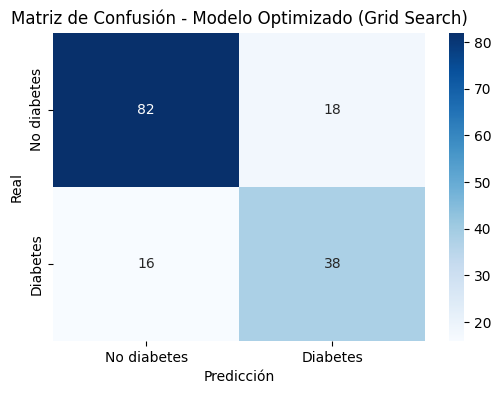

In [91]:
#Predicciones con el modelo oprimizado:
y_pred_best = best_model.predict(X_test)

# Calculamos la matriz de confusión
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['No diabetes', 'Diabetes'], 
            yticklabels=['No diabetes', 'Diabetes'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo Optimizado (Grid Search)")
plt.show()



In [92]:
# Calculamos las métricas del modelo optimizado
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

# Mostramos los resultados
print(f"Accuracy (Optimizado): {accuracy_best:.4f}")
print(f"Precision (Optimizado): {precision_best:.4f}")
print(f"Recall (Optimizado): {recall_best:.4f}")
print(f"F1-Score (Optimizado): {f1_best:.4f}")

Accuracy (Optimizado): 0.7792
Precision (Optimizado): 0.6786
Recall (Optimizado): 0.7037
F1-Score (Optimizado): 0.6909


### 🔎 Comparación de Modelos - Random Forest

| Métrica       | Sin optimizar | Optimizado (Grid Search) |
|--------------|--------------|--------------------------|
| **Accuracy**  | 74.03%       | **77.92%**             |
| **Precision** | 64.00%       | **67.86%**             |
| **Recall**    | 59.26%       | **70.37%**             |
| **F1-Score**  | 61.54%       | **69.09%**             |


Probamos Ada Boost

In [93]:
# Creamos el modelo de AdaBoost
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo
ada_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_ada = ada_model.predict(X_test)

# Calculamos las métricas
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)

# Mostramos los resultados
print(f"Accuracy (AdaBoost): {accuracy_ada:.4f}")
print(f"Precision (AdaBoost): {precision_ada:.4f}")
print(f"Recall (AdaBoost): {recall_ada:.4f}")
print(f"F1-Score (AdaBoost): {f1_ada:.4f}")

Accuracy (AdaBoost): 0.7597
Precision (AdaBoost): 0.6809
Recall (AdaBoost): 0.5926
F1-Score (AdaBoost): 0.6337


In [94]:
from sklearn.ensemble import GradientBoostingClassifier

# Creamos el modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo
gb_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test)

# Calculamos las métricas
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

# Mostramos los resultados
print(f"Accuracy (Gradient Boosting): {accuracy_gb:.4f}")
print(f"Precision (Gradient Boosting): {precision_gb:.4f}")
print(f"Recall (Gradient Boosting): {recall_gb:.4f}")
print(f"F1-Score (Gradient Boosting): {f1_gb:.4f}")

Accuracy (Gradient Boosting): 0.7468
Precision (Gradient Boosting): 0.6667
Recall (Gradient Boosting): 0.5556
F1-Score (Gradient Boosting): 0.6061


### 🔎 Comparación de Modelos de Clasificación

| Modelo                  | Accuracy  | Precision  | Recall  | F1-Score  |
|-------------------------|-----------|------------|---------|-----------|
| **Regresión Logística (Base)** | 70.13% | 58.70% | 50.00% | 54.00% |
| **Random Forest (Sin Optimizar)** | 74.03% | 64.00% | 59.26% | 61.54% |
| **Random Forest (Optimizado)** | 77.92% | 67.86% | 70.37% | 69.09% |
| **AdaBoost** | 75.97% | 68.09% | 59.26% | 63.37% |
| **Gradient Boosting** | 74.68% | 66.67% | 55.56% | 60.61% |


Optimizo los hiperparámetros del AdaBoost:

In [95]:
# Definimos los hiperparámetros a probar
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]
}

# Creamos el modelo base de AdaBoost
ada_base = AdaBoostClassifier(random_state=42)

# Aplicamos Grid Search con validación cruzada
grid_search_ada = GridSearchCV(ada_base, param_grid_ada, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Ejecutamos la búsqueda
grid_search_ada.fit(X_train, y_train)

# Mostramos los mejores parámetros encontrados
print(f"Mejores hiperparámetros (AdaBoost): {grid_search_ada.best_params_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores hiperparámetros (AdaBoost): {'estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 1, 'n_estimators': 50}


In [96]:
# Definimos el modelo optimizado con los mejores hiperparámetros
ada_opt = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1), 
    learning_rate=1, 
    n_estimators=50, 
    random_state=42
)

# Entrenamos el modelo
ada_opt.fit(X_train, y_train)

# Hacemos predicciones con el modelo optimizado
y_pred_ada_opt = ada_opt.predict(X_test)

# Calculamos las métricas
accuracy_ada_opt = accuracy_score(y_test, y_pred_ada_opt)
precision_ada_opt = precision_score(y_test, y_pred_ada_opt)
recall_ada_opt = recall_score(y_test, y_pred_ada_opt)
f1_ada_opt = f1_score(y_test, y_pred_ada_opt)

# Mostramos los resultados
print(f"Accuracy (AdaBoost Optimizado): {accuracy_ada_opt:.4f}")
print(f"Precision (AdaBoost Optimizado): {precision_ada_opt:.4f}")
print(f"Recall (AdaBoost Optimizado): {recall_ada_opt:.4f}")
print(f"F1-Score (AdaBoost Optimizado): {f1_ada_opt:.4f}")

Accuracy (AdaBoost Optimizado): 0.7468
Precision (AdaBoost Optimizado): 0.6596
Recall (AdaBoost Optimizado): 0.5741
F1-Score (AdaBoost Optimizado): 0.6139


### 🔎 Comparación de Modelos de Clasificación

| Modelo                      | Accuracy  | Precision  | Recall  | F1-Score  |
|-----------------------------|-----------|------------|---------|-----------|
| **Regresión Logística (Base)** | 70.13% | 58.70% | 50.00% | 54.00% |
| **Random Forest (Sin Optimizar)** | 74.03% | 64.00% | 59.26% | 61.54% |
| **Random Forest (Optimizado)** | 77.92% | 67.86% | 70.37% | 69.09% |
| **AdaBoost** | 75.97% | 68.09% | 59.26% | 63.37% |
| **AdaBoost Optimizado** | 74.68% | 65.96% | 57.41% | 61.39% |
| **Gradient Boosting** | 74.68% | 66.67% | 55.56% | 60.61% |


El Ada Boost optimizado no supera a la regresión logística optimizada ni al Random Forest optimizado. Pruebo XGB.

In [97]:
# Definimos el modelo de XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenamos el modelo
xgb_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Calculamos las métricas
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Mostramos los resultados
print(f"Accuracy (XGBoost): {accuracy_xgb:.4f}")
print(f"Precision (XGBoost): {precision_xgb:.4f}")
print(f"Recall (XGBoost): {recall_xgb:.4f}")
print(f"F1-Score (XGBoost): {f1_xgb:.4f}")

Accuracy (XGBoost): 0.7792
Precision (XGBoost): 0.7000
Recall (XGBoost): 0.6481
F1-Score (XGBoost): 0.6731


### 🔎 Comparación de Modelos de Clasificación

| Modelo                      | Accuracy  | Precision  | Recall  | F1-Score  |
|-----------------------------|-----------|------------|---------|-----------|
| **Regresión Logística (Base)** | 70.13% | 58.70% | 50.00% | 54.00% |
| **Random Forest (Sin Optimizar)** | 74.03% | 64.00% | 59.26% | 61.54% |
| **Random Forest (Optimizado)** | 77.92% | 67.86% | 70.37% | 69.09% |
| **AdaBoost** | 75.97% | 68.09% | 59.26% | 63.37% |
| **AdaBoost Optimizado** | 74.68% | 65.96% | 57.41% | 61.39% |
| **Gradient Boosting** | 74.68% | 66.67% | 55.56% | 60.61% |
| **XGBoost** | 77.92% | 70.00% | 64.81% | 67.31% |


Optimizo

In [98]:

# Definimos los hiperparámetros a probar
param_grid_xgb = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'learning_rate': [0.01, 0.1, 0.3],  # Tasa de aprendizaje
    'max_depth': [3, 5, 7],  # Profundidad máxima de los árboles
    'gamma': [0, 0.1, 0.5]  # Reducción de división de nodos para evitar sobreajuste
}

# Creamos el modelo base de XGBoost
xgb_base = XGBClassifier(random_state=42)

# Aplicamos Grid Search con validación cruzada
grid_search_xgb = GridSearchCV(xgb_base, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Ejecutamos la búsqueda
grid_search_xgb.fit(X_train, y_train)

# Mostramos los mejores parámetros encontrados
print(f"🔥 Mejores hiperparámetros (XGBoost): {grid_search_xgb.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
🔥 Mejores hiperparámetros (XGBoost): {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


Vuelvo a entrenar:

In [99]:
# Definimos el modelo con los hiperparámetros optimizados
xgb_opt = XGBClassifier(
    gamma=0, 
    learning_rate=0.1, 
    max_depth=5, 
    n_estimators=100, 
    random_state=42
)

# Entrenamos el modelo
xgb_opt.fit(X_train, y_train)

# Hacemos predicciones con el modelo optimizado
y_pred_xgb_opt = xgb_opt.predict(X_test)

# Calculamos las métricas
accuracy_xgb_opt = accuracy_score(y_test, y_pred_xgb_opt)
precision_xgb_opt = precision_score(y_test, y_pred_xgb_opt)
recall_xgb_opt = recall_score(y_test, y_pred_xgb_opt)
f1_xgb_opt = f1_score(y_test, y_pred_xgb_opt)

# Mostramos los resultados
print(f"Accuracy (XGBoost Optimizado): {accuracy_xgb_opt:.4f}")
print(f"Precision (XGBoost Optimizado): {precision_xgb_opt:.4f}")
print(f"Recall (XGBoost Optimizado): {recall_xgb_opt:.4f}")
print(f"F1-Score (XGBoost Optimizado): {f1_xgb_opt:.4f}")

Accuracy (XGBoost Optimizado): 0.7597
Precision (XGBoost Optimizado): 0.6667
Recall (XGBoost Optimizado): 0.6296
F1-Score (XGBoost Optimizado): 0.6476


### 🔎 Comparación de Modelos de Clasificación

| Modelo                      | Accuracy  | Precision  | Recall  | F1-Score  |
|-----------------------------|-----------|------------|---------|-----------|
| **Regresión Logística (Base)** | 70.13% | 58.70% | 50.00% | 54.00% |
| **Random Forest (Sin Optimizar)** | 74.03% | 64.00% | 59.26% | 61.54% |
| **Random Forest (Optimizado)** | 77.92% | 67.86% | 70.37% | 69.09% |
| **AdaBoost** | 75.97% | 68.09% | 59.26% | 63.37% |
| **AdaBoost Optimizado** | 74.68% | 65.96% | 57.41% | 61.39% |
| **Gradient Boosting** | 74.68% | 66.67% | 55.56% | 60.61% |
| **XGBoost** | 77.92% | 70.00% | 64.81% | 67.31% |
| **XGBoost Optimizado** | 75.97% | 66.67% | 62.96% | 64.76% |


Regresión logística y random forest siguen siendo mejores.

Por último pruebo CatBoost

In [100]:
# Definimos el modelo de CatBoost
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5, verbose=0, random_state=42)

# Entrenamos el modelo
cat_model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_cat = cat_model.predict(X_test)

# Calculamos las métricas
accuracy_cat = accuracy_score(y_test, y_pred_cat)
precision_cat = precision_score(y_test, y_pred_cat)
recall_cat = recall_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)

# Mostramos los resultados
print(f"Accuracy (CatBoost): {accuracy_cat:.4f}")
print(f"Precision (CatBoost): {precision_cat:.4f}")
print(f"Recall (CatBoost): {recall_cat:.4f}")
print(f"F1-Score (CatBoost): {f1_cat:.4f}")

Accuracy (CatBoost): 0.7338
Precision (CatBoost): 0.6327
Recall (CatBoost): 0.5741
F1-Score (CatBoost): 0.6019


### 🔎 Comparación de Modelos de Clasificación

| Modelo                      | Accuracy  | Precision  | Recall  | F1-Score  |
|-----------------------------|-----------|------------|---------|-----------|
| **Regresión Logística (Base)** | 70.13% | 58.70% | 50.00% | 54.00% |
| **Random Forest (Sin Optimizar)** | 74.03% | 64.00% | 59.26% | 61.54% |
| **Random Forest (Optimizado)** | 77.92% | 67.86% | 70.37% | 69.09% |
| **AdaBoost** | 75.97% | 68.09% | 59.26% | 63.37% |
| **AdaBoost Optimizado** | 74.68% | 65.96% | 57.41% | 61.39% |
| **Gradient Boosting** | 74.68% | 66.67% | 55.56% | 60.61% |
| **XGBoost** | 77.92% | 70.00% | 64.81% | 67.31% |
| **XGBoost Optimizado** | 75.97% | 66.67% | 62.96% | 64.76% |
| **CatBoost** | 73.38% | 63.27% | 57.41% | 60.19% |


Optimizo con Grid search

In [101]:
# Definimos los hiperparámetros a probar
param_grid_cat = {
    'iterations': [50, 100, 200],  # Número de árboles
    'learning_rate': [0.01, 0.1, 0.3],  # Tasa de aprendizaje
    'depth': [3, 5, 7],  # Profundidad máxima del árbol
    'l2_leaf_reg': [1, 3, 5]  # Regularización L2 para evitar sobreajuste
}

# Creamos el modelo base de CatBoost
cat_base = CatBoostClassifier(verbose=0, random_state=42)

# Aplicamos Grid Search con validación cruzada
grid_search_cat = GridSearchCV(cat_base, param_grid_cat, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Ejecutamos la búsqueda
grid_search_cat.fit(X_train, y_train)

# Mostramos los mejores parámetros encontrados
print(f"Mejores hiperparámetros (CatBoost): {grid_search_cat.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros (CatBoost): {'depth': 7, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [102]:
# Definimos el modelo con los hiperparámetros optimizados
cat_opt = CatBoostClassifier(
    depth=7,
    iterations=100,
    l2_leaf_reg=3,
    learning_rate=0.1,
    verbose=0,
    random_state=42
)

# Entrenamos el modelo
cat_opt.fit(X_train, y_train)

# Hacemos predicciones con el modelo optimizado
y_pred_cat_opt = cat_opt.predict(X_test)

# Calculamos las métricas
accuracy_cat_opt = accuracy_score(y_test, y_pred_cat_opt)
precision_cat_opt = precision_score(y_test, y_pred_cat_opt)
recall_cat_opt = recall_score(y_test, y_pred_cat_opt)
f1_cat_opt = f1_score(y_test, y_pred_cat_opt)

# Mostramos los resultados
print(f"Accuracy (CatBoost Optimizado): {accuracy_cat_opt:.4f}")
print(f"Precision (CatBoost Optimizado): {precision_cat_opt:.4f}")
print(f"Recall (CatBoost Optimizado): {recall_cat_opt:.4f}")
print(f"F1-Score (CatBoost Optimizado): {f1_cat_opt:.4f}")

Accuracy (CatBoost Optimizado): 0.7403
Precision (CatBoost Optimizado): 0.6522
Recall (CatBoost Optimizado): 0.5556
F1-Score (CatBoost Optimizado): 0.6000


### 🔎 Comparación de Modelos de Clasificación

| Modelo                      | Accuracy  | Precision  | Recall  | F1-Score  |
|-----------------------------|-----------|------------|---------|-----------|
| **Regresión Logística (Base)** | 70.13% | 58.70% | 50.00% | 54.00% |
| **Random Forest (Sin Optimizar)** | 74.03% | 64.00% | 59.26% | 61.54% |
| **Random Forest (Optimizado)** | 77.92% | 67.86% | 70.37% | 69.09% |
| **AdaBoost** | 75.97% | 68.09% | 59.26% | 63.37% |
| **AdaBoost Optimizado** | 74.68% | 65.96% | 57.41% | 61.39% |
| **Gradient Boosting** | 74.68% | 66.67% | 55.56% | 60.61% |
| **XGBoost** | 77.92% | 70.00% | 64.81% | 67.31% |
| **XGBoost Optimizado** | 75.97% | 66.67% | 62.96% | 64.76% |
| **CatBoost** | 73.38% | 63.27% | 57.41% | 60.19% |
| **CatBoost Optimizado** | 74.03% | 65.22% | 55.56% | 60.00% |


Comparación de modelos con validación cruzada

In [103]:


# Lista de modelos a comparar
modelos = {
    "Regresión Logística": logistic_model,
    "Random Forest Optimizado": best_model,
    "AdaBoost Optimizado": ada_opt,
    "Gradient Boosting": gb_model,
    "XGBoost Optimizado": xgb_opt,
    "CatBoost Optimizado": cat_opt
}

# Evaluamos cada modelo con validación cruzada
for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='f1')
    print(f"{nombre}: F1-Score promedio = {scores.mean():.4f} ± {scores.std():.4f}")

Regresión Logística: F1-Score promedio = 0.6610 ± 0.0236
Random Forest Optimizado: F1-Score promedio = 0.6887 ± 0.0372
AdaBoost Optimizado: F1-Score promedio = 0.6332 ± 0.0279
Gradient Boosting: F1-Score promedio = 0.6333 ± 0.0566
XGBoost Optimizado: F1-Score promedio = 0.6351 ± 0.0473
CatBoost Optimizado: F1-Score promedio = 0.6530 ± 0.0746


Si se busca la mejor capacidad de detectar correctamente los casos de diabetes nos quedamos con un Random Forest Optimizado.